Import neccessary libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Read cab_rides and weather

In [ ]:
cab_rides_df = pd.read_csv('cab_rides.csv')
weather_df = pd.read_csv('weather.csv')

Remove duplicates

In [ ]:
cab_rides_df = cab_rides_df.drop_duplicates()
weather_df = weather_df.drop_duplicates()

Format by source and destination

In [ ]:
cab_rides_df = cab_rides_df.dropna(axis=0).reset_index(drop=True)
weather_df = weather_df.fillna(0)

In [ ]:
avg_weather_df = weather_df.groupby('location').mean().reset_index(drop=False)
avg_weather_df = avg_weather_df.drop('time_stamp', axis=1)

In [ ]:
source_weather_df = avg_weather_df.rename(
    columns={
        'location': 'source',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'rain': 'source_rain',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

In [ ]:
destination_weather_df = avg_weather_df.rename(
    columns={
        'location': 'destination',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'rain': 'destination_rain',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'
    }
)

Merge into a new data frame

In [ ]:
merged_data = cab_rides_df\
    .merge(source_weather_df, on='source')\
    .merge(destination_weather_df, on='destination')

merged_data.dropna(inplace=True)

Feature signficance in price

In [ ]:
price_threshold = merged_data['price'].median()
merged_data['cost_category'] = merged_data['price'].apply(lambda x: 1 if x > price_threshold else 0)

In [ ]:
# Feature Engineering
# Extracting the Day of the Week and Hour from the Timestamp

merged_data['day_of_week'] = pd.to_datetime(merged_data['time_stamp']).dt.dayofweek
merged_data['hour'] = pd.to_datetime(merged_data['time_stamp']).dt.hour

In [ ]:
# Features only used for prediction

features = ['distance', 'surge_multiplier', 'source_temp', 'destination_temp', 'source_rain', 'destination_rain', 'day_of_week', 'hour']
X = merged_data[features]
y = merged_data['cost_category']

In [ ]:
# Standardize numerical features for better performance

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initializing and training the Decision Tree classifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Make predictions and evaluate the model

y_pred = clf.predict(X_test)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.607132967245406
              precision    recall  f1-score   support

           0       0.62      0.58      0.60     96423
           1       0.60      0.63      0.62     94970

    accuracy                           0.61    191393
   macro avg       0.61      0.61      0.61    191393
weighted avg       0.61      0.61      0.61    191393



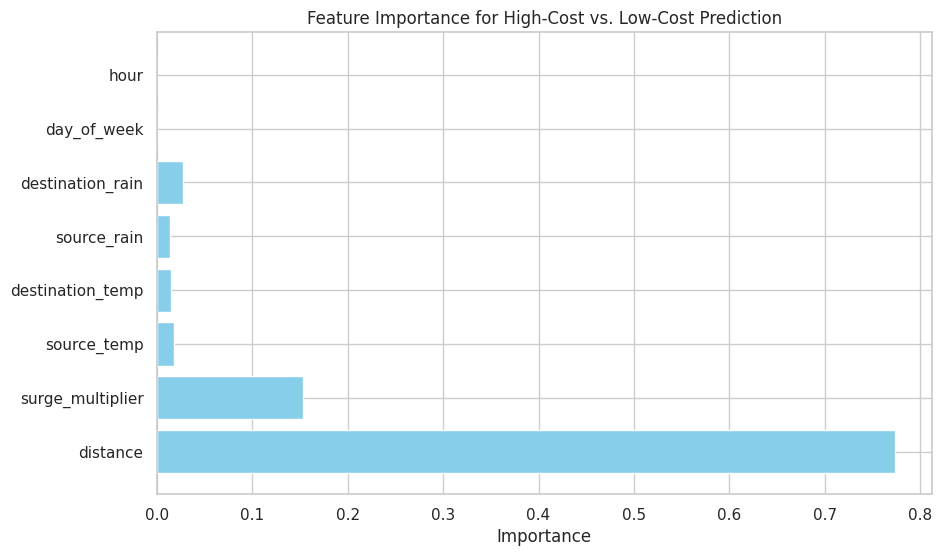

In [ ]:
importances = clf.feature_importances_
feature_names = features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for High-Cost vs. Low-Cost Prediction')
plt.show()


In [ ]:
def calculate_wsi(row, temp_min, temp_max, cloud_max, wind_max):
    # Normalize temperature severity using min-max scaling
    temp_severity = (row['source_temp'] - temp_min) / (temp_max - temp_min)
    temp_severity = np.clip(temp_severity, 0, 1)  # Ensure values are between 0 and 1

    # Normalize cloud cover severity
    cloud_severity = row['source_clouds'] / cloud_max  # Assuming cloud cover max is 100
    cloud_severity = np.clip(cloud_severity, 0, 1)

    # Rain severity (binary)
    rain_severity = 1 if row['source_rain'] > 0 else 0

    # Normalize humidity severity
    humidity_severity = row['source_humidity'] / 100  # Assuming humidity max is 100
    humidity_severity = np.clip(humidity_severity, 0, 1)

    # Normalize wind severity using min-max scaling
    wind_severity = row['source_wind'] / wind_max  # Assuming typical max wind speed
    wind_severity = np.clip(wind_severity, 0, 1)

    # Calculate WSI as a weighted sum
    WSI = (0.2 * temp_severity +
           0.15 * cloud_severity +
           0.3 * rain_severity +
           0.15 * humidity_severity +
           0.2 * wind_severity)

    return WSI

In [ ]:
# Determine the min and max values for each feature
temp_min, temp_max = merged_data['source_temp'].min(), merged_data['source_temp'].max()
cloud_max = merged_data['source_clouds'].max()
wind_max = merged_data['source_wind'].max()

# Apply the WSI function with these parameters
merged_data['WSI'] = merged_data.apply(lambda row: calculate_wsi(row, temp_min, temp_max, cloud_max, wind_max), axis=1)

# Display the DataFrame with the new WSI column
print(merged_data[['source_temp', 'source_clouds', 'source_rain', 'source_humidity', 'source_wind', 'WSI']])


        source_temp  source_clouds  source_rain  source_humidity  source_wind  \
0         39.067897       0.676711     0.008660         0.764837     6.843193   
1         39.067897       0.676711     0.008660         0.764837     6.843193   
2         39.067897       0.676711     0.008660         0.764837     6.843193   
3         39.067897       0.676711     0.008660         0.764837     6.843193   
4         39.067897       0.676711     0.008660         0.764837     6.843193   
...             ...            ...          ...              ...          ...   
637971    38.983403       0.677247     0.008657         0.767266     6.816233   
637972    38.983403       0.677247     0.008657         0.767266     6.816233   
637973    38.983403       0.677247     0.008657         0.767266     6.816233   
637974    38.983403       0.677247     0.008657         0.767266     6.816233   
637975    38.983403       0.677247     0.008657         0.767266     6.816233   

             WSI  
0       

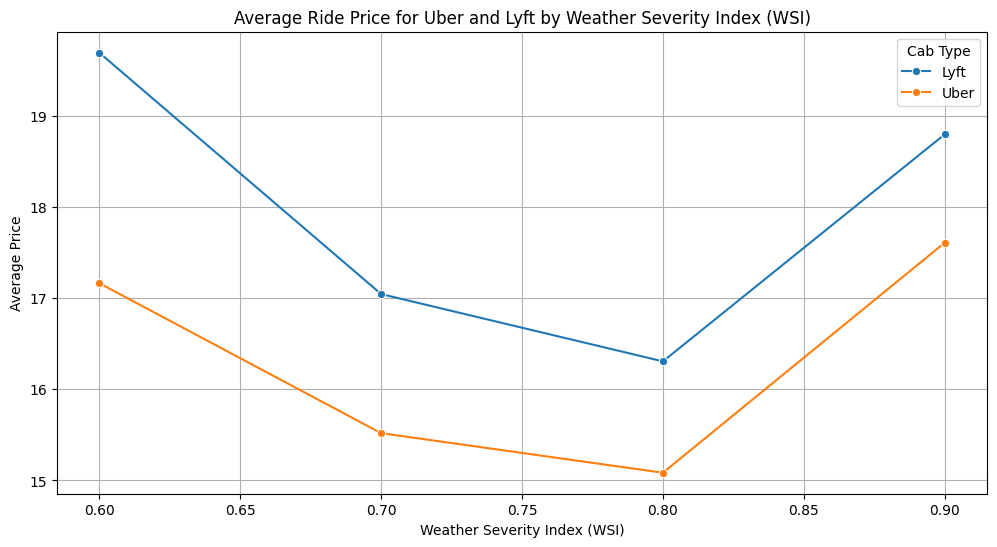

In [ ]:
# Calculate the average price (or count) for each cab type across WSI levels
# For simplicity, round WSI to 1 decimal to group by similar severity levels
merged_data['WSI'] = merged_data['WSI'].round(1)

# Group by WSI and cab_type, calculate mean price
wsi_avg = merged_data.groupby(['WSI', 'cab_type']).price.mean().reset_index()

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=wsi_avg, x='WSI', y='price', hue='cab_type', marker="o")

# Add labels and title
plt.title("Average Ride Price for Uber and Lyft by Weather Severity Index (WSI)")
plt.xlabel("Weather Severity Index (WSI)")
plt.ylabel("Average Price")
plt.legend(title='Cab Type')
plt.grid()

# Show the plot
plt.show()

In [ ]:

# Example data (replace this with loading your actual dataset)
data = {
    'distance': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Define distance bins and labels
bins = [0, 3, 6, float('inf')]  # float('inf') represents infinity for the last bin
labels = ['Short', 'Medium', 'Long']

# Create a new column for distance bins
merged_data['distance_bin'] = pd.cut(merged_data['distance'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new distance bin column
merged_data['distance_bin']


,distance_bin
0,Short
1,Short
2,Short
3,Short
4,Short
...,...
637971,Short
637972,Short
637973,Short
637974,Short


<ipython-input-173-1d8b1c6ffaba>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = merged_data.groupby(['cab_type', 'distance_bin']).size().reset_index(name='count')


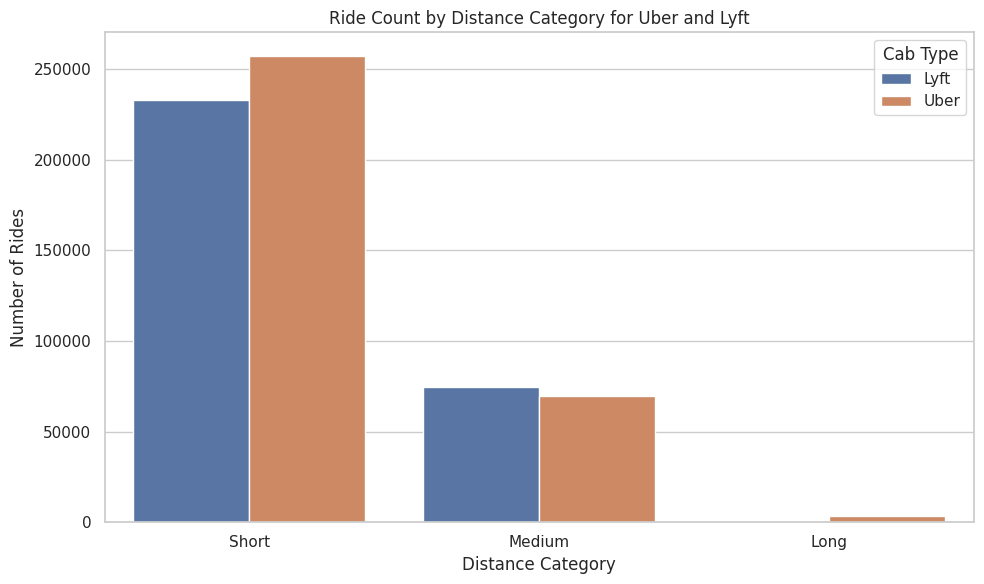

In [ ]:
# Count the number of rides in each category for Uber and Lyft
category_counts = merged_data.groupby(['cab_type', 'distance_bin']).size().reset_index(name='count')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=category_counts, x='distance_bin', y='count', hue='cab_type')

# Customize the plot
plt.title('Ride Count by Distance Category for Uber and Lyft')
plt.xlabel('Distance Category')
plt.ylabel('Number of Rides')
plt.legend(title='Cab Type')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Create new columns for uber_price and lyft_price
merged_data['uber_price'] = merged_data['price'].where(merged_data['cab_type'] == 'Uber', 0)
merged_data['lyft_price'] = merged_data['price'].where(merged_data['cab_type'] == 'Lyft', 0)

# Display the DataFrame with the new price columns
print(merged_data[['distance', 'cab_type', 'price', 'uber_price', 'lyft_price']])

        distance cab_type  price  uber_price  lyft_price
10398       0.02     Uber   27.5        27.5         0.0
159255      0.02     Uber   27.5        27.5         0.0
473890      0.02     Uber    6.5         6.5         0.0
392006      0.02     Uber    5.5         5.5         0.0
10395       0.02     Uber    7.5         7.5         0.0
...          ...      ...    ...         ...         ...
606395      7.86     Uber   53.0        53.0         0.0
606393      7.86     Uber   17.5        17.5         0.0
606392      7.86     Uber   36.0        36.0         0.0
606396      7.86     Uber   29.5        29.5         0.0
606394      7.86     Uber   13.5        13.5         0.0

[637976 rows x 5 columns]


In [ ]:
# Create a binary target variable for significant price difference
threshold = 0.5  # Define a threshold for significant price difference
merged_data['price_difference'] = (merged_data['uber_price'] - merged_data['lyft_price']).abs()
merged_data['significant_difference'] = np.where(merged_data['price_difference'] > threshold * merged_data[['uber_price', 'lyft_price']].max(axis=1), 1, 0)

# Select features for the model
features = ['source_humidity', 'destination_humidity', 'source_rain', 'source_temp', 'destination_temp', 'WSI']
X = pd.get_dummies(merged_data[features], drop_first=True)  # Convert categorical variable to dummy variables
y = merged_data['significant_difference']


In [ ]:
merged_data['significant_difference']

,significant_difference
10398,1
159255,1
473890,1
392006,1
10395,1
...,...
606395,1
606393,1
606392,1
606396,1


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=77)

In [ ]:
# Initialize the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, random_state=99)

# Fit the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=99)

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


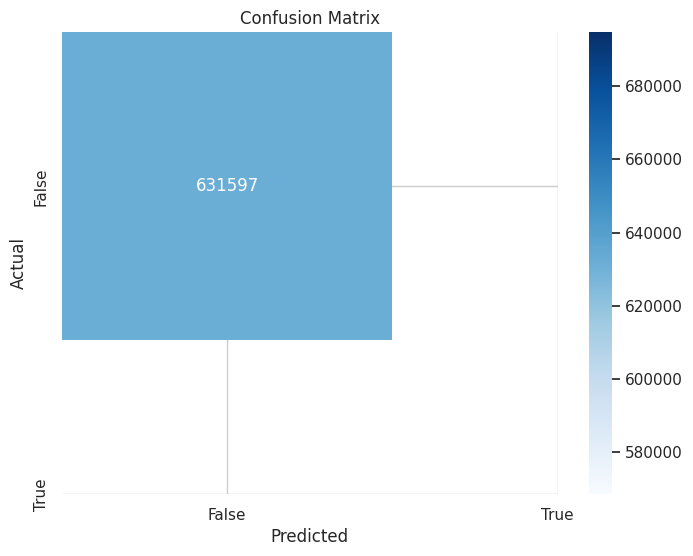

              precision    recall  f1-score   support

           1       1.00      1.00      1.00    631597

    accuracy                           1.00    631597
   macro avg       1.00      1.00      1.00    631597
weighted avg       1.00      1.00      1.00    631597



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


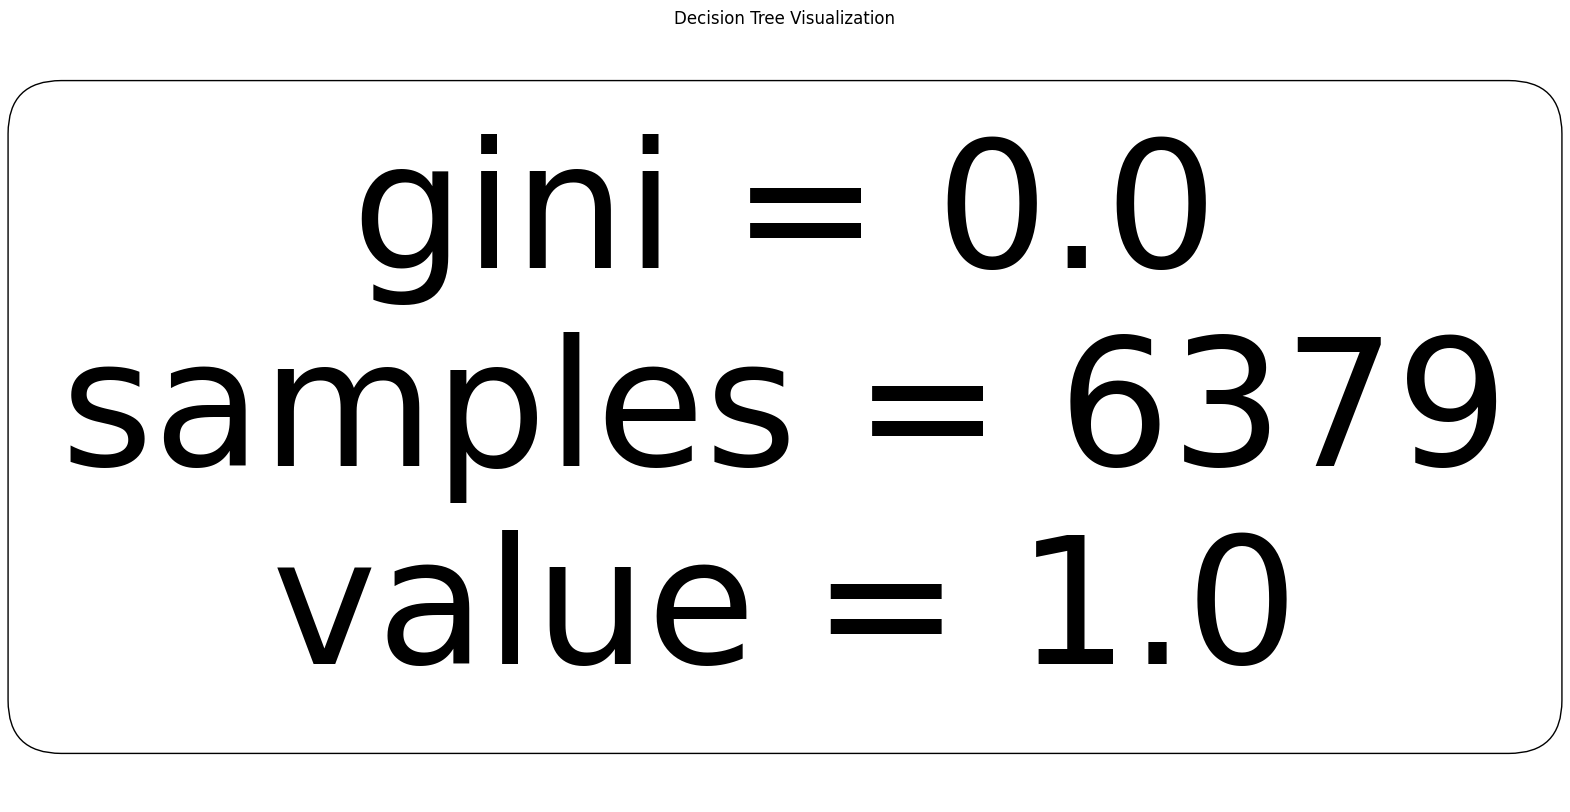

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No Significant Difference', 'Significant Difference'], rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


In [ ]:
# Define a threshold for price categorization (e.g., median price)
price_threshold = merged_data['price'].median()

# Create a binary target variable for significant price
merged_data['high_price'] = np.where(merged_data['price'] > price_threshold, 1, 0)  # 1 for high price, 0 for low price

# Check the new target variable
print(merged_data[['price', 'high_price']].head())


   price  high_price
0    5.0           0
1   11.0           0
2    7.0           0
3   26.0           1
4    9.0           0


In [ ]:
# Select features for the model
features = ['distance']
X = merged_data[features]
y = merged_data['high_price']


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the decision tree classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

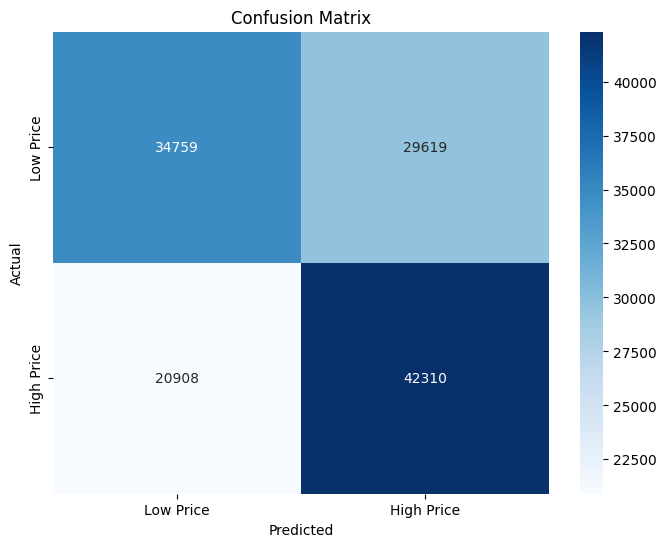

              precision    recall  f1-score   support

           0       0.62      0.54      0.58     64378
           1       0.59      0.67      0.63     63218

    accuracy                           0.60    127596
   macro avg       0.61      0.60      0.60    127596
weighted avg       0.61      0.60      0.60    127596



In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Price', 'High Price'], yticklabels=['Low Price', 'High Price'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


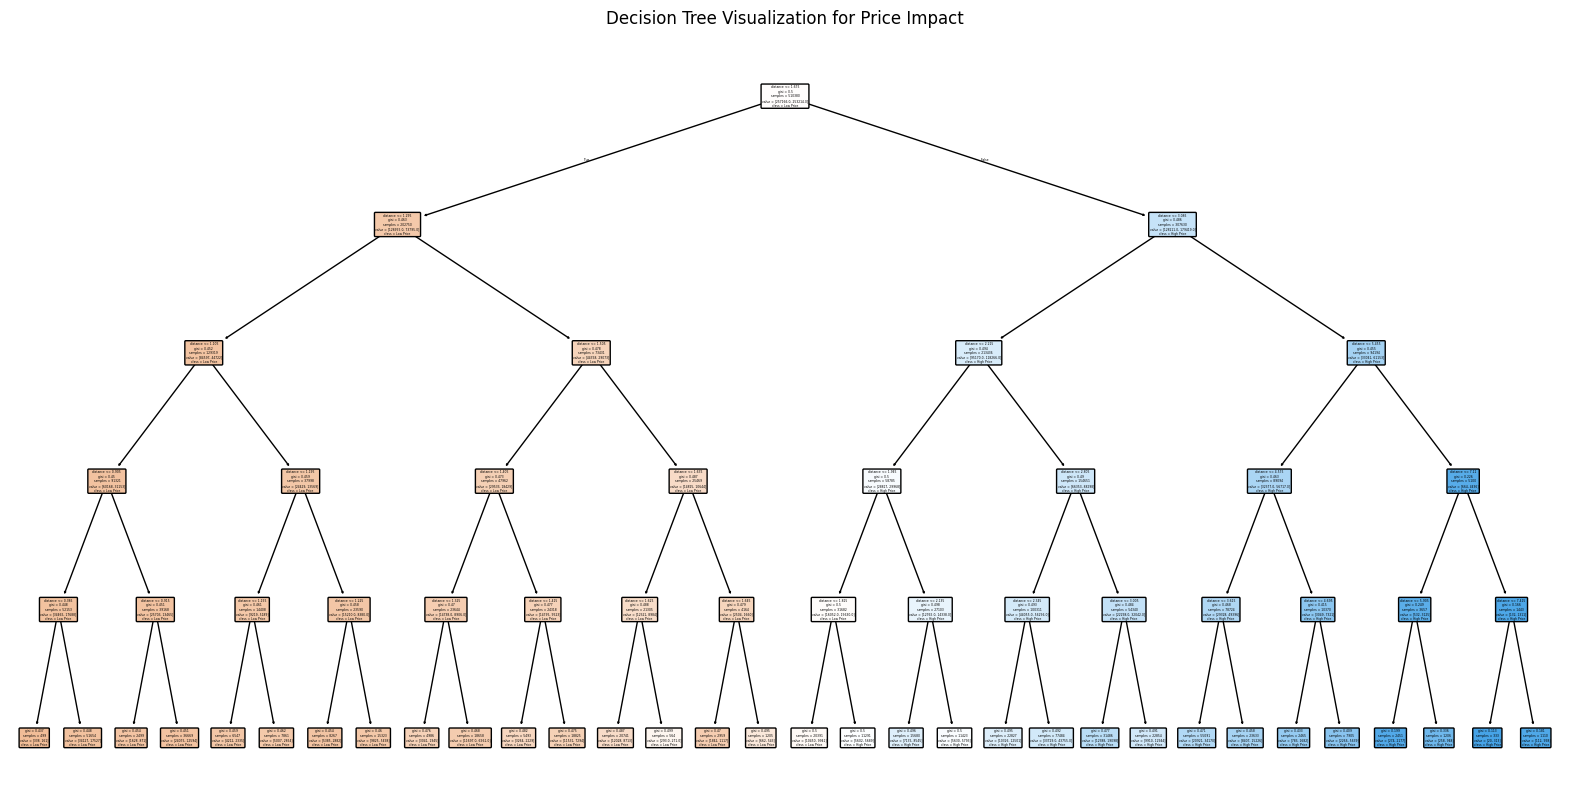

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))g
plot_tree(clf, filled=True, feature_names=features, class_names=['Low Price', 'High Price'], rounded=True)
plt.title('Decision Tree Visualization for Price Impact')
plt.show()



In [ ]:
# Calculate average prices for Uber and Lyft
average_prices = merged_data[['uber_price', 'lyft_price']].mean()

# Convert to DataFrame for easier plotting
average_prices_df = pd.DataFrame(average_prices).reset_index()
average_prices_df.columns = ['Service', 'Average Price']

# Display the average prices
print(average_prices_df)

      Service  Average Price
0  uber_price       8.184375
1  lyft_price       8.360750


In [ ]:


# Sort the data by time_stamp
merged_data = merged_data.sort_values('distance')

# Display the first few rows to check the sorting
print(merged_data[['distance', 'uber_price', 'lyft_price']].head())


        distance  uber_price  lyft_price
10398       0.02        27.5         0.0
159255      0.02        27.5         0.0
473890      0.02         6.5         0.0
392006      0.02         5.5         0.0
10395       0.02         7.5         0.0


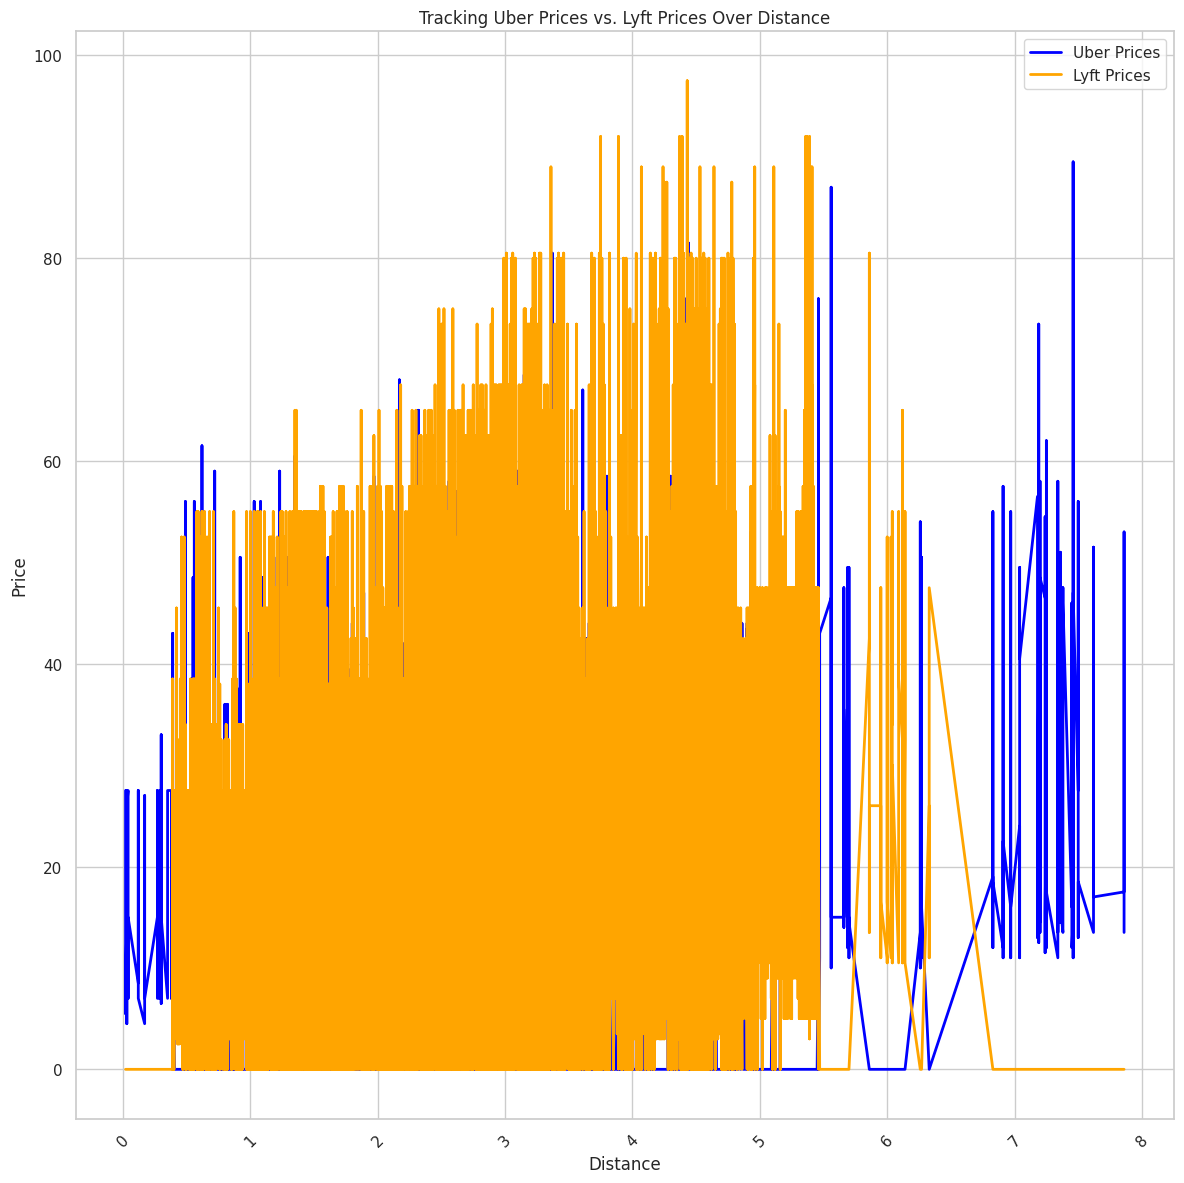

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 12))
plt.plot(merged_data['distance'], merged_data['uber_price'], label='Uber Prices', color='blue', linewidth=2)
plt.plot(merged_data['distance'], merged_data['lyft_price'], label='Lyft Prices', color='orange', linewidth=2)

# Add titles and labels
plt.title('Tracking Uber Prices vs. Lyft Prices Over Distance')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for labels

# Show the plot
plt.show()
